In [53]:
# Libraries and dependencies
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.distributions as distributions
import torch.optim as optim
import matplotlib.pyplot as plt

In [54]:
# Training environment (wind disabled)
env = gym.make(
    "LunarLander-v3",
    continuous=False,     
    gravity=-10.0,        
    enable_wind=False,   
    wind_power=15.0,      
    turbulence_power=1.0, 
    render_mode="rgb_array" 
)

# Evaluation environment (wind enabled)
video_env = gym.make(
    "LunarLander-v3",
    continuous=False,     
    gravity=-10.0,        
    enable_wind=False,   
    wind_power=15.0,      
    turbulence_power=1.0, 
    render_mode="rgb_array" 
)

# Record video every 100 epochs
video_env = RecordVideo(video_env, video_folder="a2c_1e6_64_2048_3e4_gae", episode_trigger=lambda x: x % 1000 == 0)   

In [55]:
space_dim = env.observation_space.shape[0]      # Observation space: 8-dimensional vector
action_dim = env.action_space.n                 # Action space: 4 discrete actions

# Training parameters (following paper)
gamma = 0.99                # Discount factor
lr = 3e-4                   # Learning rate
lamb = 0.95                 # Generalised Advantage Estimation (GAE) lambda
epsilon = 0.2               # Clipping value
h = 0.01                    # Entropy coefficient
max_timesteps = 1e6         # Maximal number of iterations
eval_episodes = 100         # Episodes for evaluation
N = 1                       # Number of agents collecting training data
T = 2048                    # Maximal trajectory length
K = 10                      # Number of epoches per update
minibatch_size = 64         # Size of a mini batch
number_minibatches = N * T / minibatch_size     # Number of mini batches
actor_losses = []           # For plotting
critic_losses = []
eval_rewards = []            
index = []

In [56]:
# The network to select an action
ActorNetwork = nn.Sequential(
    nn.Linear(space_dim, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, action_dim)
)

# The network to get value of a state
CriticNetwork = nn.Sequential(
    nn.Linear(space_dim, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 1)
)

# Optimizer using Adam Gradient Descent
actor_optimizer = optim.Adam(ActorNetwork.parameters(), lr=lr)
critic_optimizer = optim.Adam(CriticNetwork.parameters(), lr=lr)

In [57]:
def select_action(state_tensor):
    value = CriticNetwork(state_tensor)
    action_pred = ActorNetwork(state_tensor)                    
    dist = distributions.Categorical(logits=action_pred)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    return action, value, log_prob

In [58]:
def collect_training_data(state, action, reward, log_prob, value, done, states, actions, rewards, log_probs, values, dones):
    states.append(state)         # Collect states
    actions.append(action)        # Collect actions from Actor Network
    rewards.append(reward)        # Collect rewards
    log_probs.append(log_prob)      # Collect lob_probs
    values.append(value)         # Collect values from Critic Network
    dones.append(done)          # Collect done (0 or 1)

In [59]:
def compute_GAE(next_value, rewards, values, dones):
    advantages = []
    GAE = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * next_value * (1 - dones[t]) - values[t]      # TD error
        GAE = delta + gamma * lamb * (1 - dones[t]) * GAE
        advantages.insert(0, GAE)
        next_value = values[t].item()
    return advantages

In [60]:
def compute_advantages(next_state_tensor: torch.Tensor, rewards: list, values: list, dones: list):
    next_value = CriticNetwork(next_state_tensor)                                           # Calculate the next value
    advantages = compute_GAE(next_value, rewards=rewards, values=values, dones=dones)       # Calculate advantage using GAE
    advantages = torch.FloatTensor(advantages)              
    return advantages

In [61]:
def get_parameterized_policy(batch_states, batch_actions):
    optimized_value = CriticNetwork(batch_states)
    optimized_action_preds = ActorNetwork(batch_states)
    optimized_dist = distributions.Categorical(logits=optimized_action_preds)
    optimized_log_probs = optimized_dist.log_prob(batch_actions)

    return optimized_value, optimized_dist, optimized_log_probs

In [62]:
def evaluation(eval_episodes):
    total_reward = 0
    for _ in range(eval_episodes):
        episode_reward = 0
        state, _ = video_env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state)
            action_pred = ActorNetwork(state_tensor)
            action = torch.argmax(action_pred).item()
            state, reward, terminated, truncated, _ = video_env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_reward += episode_reward
    return total_reward / eval_episodes  

In [63]:
state, _ = env.reset()      # Initialize state s_t
timesteps = 0

while timesteps < max_timesteps:
    states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
    print(timesteps)

    for _ in range(T):              # Collect T timesteps for 1 rollout
        action, value, log_prob = select_action(torch.FloatTensor(state)) # Get action a_t, value V(s)_t, and old policy given action a_t

        next_state, reward, terminated, truncated, _ = env.step(action.item())      # Advance simulation one time step
        done = terminated or truncated

        # Collect training data
        collect_training_data(state, action, reward, log_prob, value, done, states, actions, rewards, log_probs, values, dones)  

        state = next_state      # Move to next state
        timesteps += 1          # Increase timesteps

        if done:
            state, _ = env.reset()      # If an episode is done, reset the state
    
    # Compute advantages
    advantages = compute_advantages(next_state_tensor=torch.FloatTensor(state), rewards=rewards, values=values, dones=dones)     # Calculate advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)               # Normalize advantages
    returns = advantages + torch.FloatTensor(values)        # Calculate V_target_t = A_t + V_w(s_t)

    # Convert data for training 
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    old_log_probs = torch.FloatTensor(log_probs)
    returns = returns.detach()

    # Optimizing the surrogate loss
    for k in range(K):          
        for i in torch.randperm(len(states)).split(minibatch_size):        # Sample over batches with size 'minibatch_size'      
            batch_states = states[i]
            batch_actions = actions[i]
            batch_old_log_probs = old_log_probs[i]
            batch_returns = returns[i]
            batch_advantages = advantages[i]

            optimized_value, optimized_dist, optimized_log_probs = get_parameterized_policy(batch_states=batch_states, batch_actions=batch_actions)
            H_entropy = optimized_dist.entropy().mean()

            actor_loss = -(optimized_log_probs * batch_advantages).mean() - h * H_entropy
            critic_loss = (optimized_value.squeeze() - batch_returns).pow(2).mean()  

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
            
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

    if timesteps % T == 0:
        try:
            avg_rewards = evaluation(eval_episodes)
            print(f"In current timestep: {timesteps}, average reward: {avg_rewards}", flush=True)
            index.append(timesteps)
            eval_rewards.append(avg_rewards)
        except Exception as e:
            print(f"Error in evaluation: {e}", flush=True)

0
In current timestep: 2048, average reward: -358.1308860370702
2048
In current timestep: 4096, average reward: -653.103434634314
4096
In current timestep: 6144, average reward: -499.1546903361736
6144
In current timestep: 8192, average reward: -481.5615642558028
8192
In current timestep: 10240, average reward: -431.8320077593694
10240
In current timestep: 12288, average reward: -541.855221139099
12288
In current timestep: 14336, average reward: -594.4180884015598
14336
In current timestep: 16384, average reward: -517.1644595161505
16384
In current timestep: 18432, average reward: -564.61558766905
18432
In current timestep: 20480, average reward: -566.5788798793941
20480
In current timestep: 22528, average reward: -581.9534653431429
22528
In current timestep: 24576, average reward: -572.2342069125156
24576
In current timestep: 26624, average reward: -538.6505823521575
26624
In current timestep: 28672, average reward: -575.0596017205459
28672
In current timestep: 30720, average reward: 

In [64]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

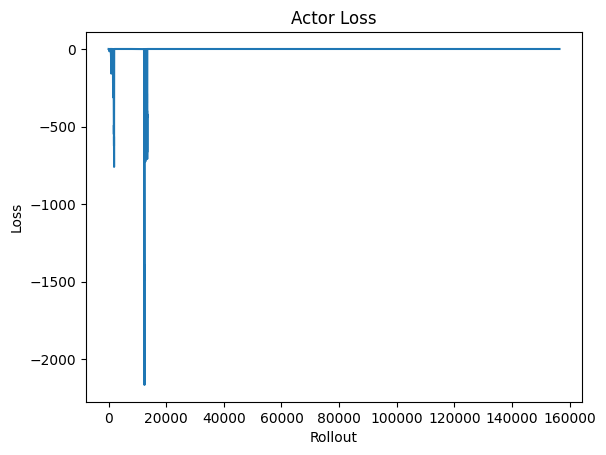

In [65]:
plt.plot(moving_average(actor_losses))
plt.title("Actor Loss")
plt.xlabel("Rollout")
plt.ylabel("Loss")
plt.show()

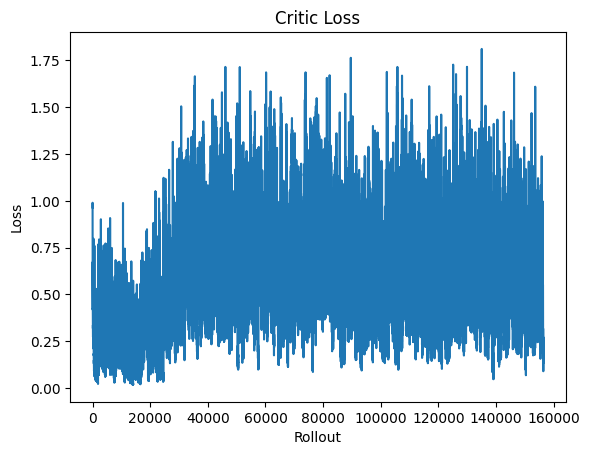

In [66]:
plt.plot(moving_average(critic_losses))
plt.title("Critic Loss")
plt.xlabel("Rollout")
plt.ylabel("Loss")
plt.show()

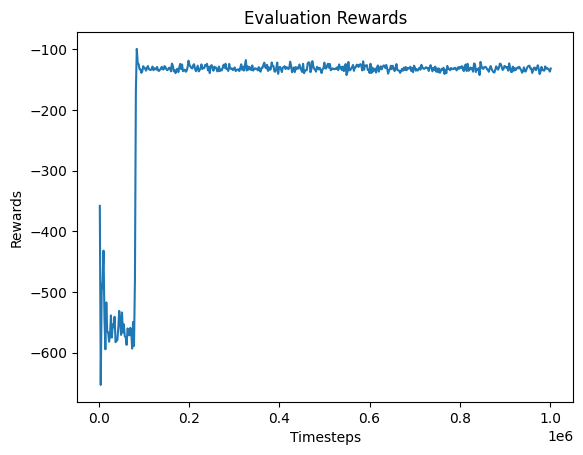

In [67]:
plt.plot(index, eval_rewards)
plt.title("Evaluation Rewards")
plt.xlabel("Timesteps")
plt.ylabel("Rewards")
plt.show()